In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import os
from typing import Tuple, List, Type
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.nn.functional import cross_entropy
from torch.utils.data import random_split, DataLoader
from tqdm import tqdm
from torch.functional import F

from src.metrics import get_model_flops, get_num_parameters
from src.reference import ReferenceModel
from src.data import RotatedMNISTDataset, FixedSizeWrapper
from src.binary_tree import MNISTOracleRouter, BinaryTreeGoE, LatentVariableRouter, RandomBinaryTreeRouter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Helper Functions

In [3]:
def build_modules_sqA(param_factor: int) -> Tuple[Type[nn.Module], Type[nn.Module], Type[nn.Module]]:
    """
    Architecture factory for Status Quo A Model for RotatedMNIST task which has the same number of *total* parameters as the Graph of Experts. Takes in hyperparameter param_factor, outputs list of module architectures which scale linearly in param_factor
    """
    class LayerOne(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv = nn.Conv2d(1, param_factor, kernel_size=3, padding=1)
    
        def forward(self, x: torch.Tensor):
            """
            Args:
            - x: (batch_size, 1, 28, 28)
            """
            return F.relu(F.max_pool2d(self.conv(x), 2))  # (batch_size, param_factor, 14, 14)
    
    class LayerTwo(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv = nn.Conv2d(param_factor, 2 * 2 * param_factor, kernel_size=3, padding=1)
    
        def forward(self, x: torch.Tensor):
            """
            Args:
            - x: (batch_size, 32, 14, 14)
            """
            return F.relu(F.max_pool2d(self.conv(x), 2))  # (batch_size, 2 * 2 * param_factor, 7, 7)
    
    class LayerThree(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(2 * 2 * param_factor * 7 * 7, 2 * 4 * param_factor)
            self.fc2 = nn.Linear(2 * 4 * param_factor, 10)
    
        def forward(self, x: torch.Tensor):
            """
            Args:
            - x: (batch_size, 128, 7, 7)
            """
            x = x.view(-1, 2 * 2 * param_factor * 7 * 7)  # (batch_size, 2 * 2 * param_factor * 7 * 7)
            x = F.relu(self.fc1(x))  # (batch_size, 2 * 4 * param_factor)
            logits = self.fc2(x)  # (batch_size, 10)
            return logits
    return LayerOne, LayerTwo, LayerThree

In [4]:
def build_modules(param_factor: int) -> Tuple[Type[nn.Module], Type[nn.Module], Type[nn.Module]]:
    """
    Architecture factory for RotatedMNIST task. Takes in hyperparameter param_factor, outputs list of module architectures which scale linearly in param_factor
    """
    class LayerOne(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv = nn.Conv2d(1, param_factor, kernel_size=3, padding=1)
    
        def forward(self, x: torch.Tensor):
            """
            Args:
            - x: (batch_size, 1, 28, 28)
            """
            return F.relu(F.max_pool2d(self.conv(x), 2))  # (batch_size, param_factor, 14, 14)
    
    class LayerTwo(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv = nn.Conv2d(param_factor, 2 * param_factor, kernel_size=3, padding=1)
    
        def forward(self, x: torch.Tensor):
            """
            Args:
            - x: (batch_size, 32, 14, 14)
            """
            return F.relu(F.max_pool2d(self.conv(x), 2))  # (batch_size, 2 * param_factor, 7, 7)
    
    class LayerThree(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(2 * param_factor * 7 * 7, 4 * param_factor)
            self.fc2 = nn.Linear(4 * param_factor, 10)
    
        def forward(self, x: torch.Tensor):
            """
            Args:
            - x: (batch_size, 64, 7, 7)
            """
            x = x.view(-1, 2 * param_factor * 7 * 7)  # (batch_size, 2 * param_factor * 7 * 7)
            x = F.relu(self.fc1(x))  # (batch_size, 4 * param_factor)
            logits = self.fc2(x)  # (batch_size, 10)
            return logits
    return LayerOne, LayerTwo, LayerThree

In [5]:

def do_train_epoch(model, loader, optimizer, epoch) -> float:
    model.train()
    epoch_losses = []
    for idx, (images, rotation_labels, digit_labels) in enumerate(loader):
        images = images.to(device)
        rotation_labels = rotation_labels.to(device)
        digit_labels = digit_labels.to(device)

        router_metadata = {
            "rotation_labels": rotation_labels,
        }

        optimizer.zero_grad()
        logits = model(images, router_metadata=router_metadata) # (bs, num_digit_classes)
        loss = cross_entropy(logits, digit_labels)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    epoch_loss = torch.mean(torch.Tensor(epoch_losses)).item()
    # print(f'Train epoch {epoch} loss: {epoch_loss:.4f}')
    return epoch_loss

def do_val_epoch(model, loader, epoch) -> float:
    model.eval()
    epoch_losses = []
    for idx, (images, rotation_labels, digit_labels) in tqdm(enumerate(loader)):
        images = images.to(device)
        rotation_labels = rotation_labels.to(device)
        digit_labels = digit_labels.to(device)
        
        router_metadata = {
            "rotation_labels": rotation_labels,
        }

        logits = model(images, router_metadata=router_metadata) # (bs, num_digit_classes)
        loss = cross_entropy(logits, digit_labels)
        epoch_losses.append(loss.item())
    epoch_loss = torch.mean(torch.Tensor(epoch_losses)).item()
    # print(f'Val epoch {epoch} loss: {epoch_loss:.4f}') 
    return epoch_loss

def get_accuracy(model, loader):
    model.eval()
    total_samples = 0
    total_correct = 0
    for idx, (images, rotation_labels, digit_labels) in enumerate(loader):
        images = images.to(device)
        rotation_labels = rotation_labels.to(device)
        digit_labels = digit_labels.to(device) # (bs,)
        
        router_metadata = {
            "rotation_labels": rotation_labels,
        }

        logits = model(images, router_metadata=router_metadata) # (bs, num_digit_classes)
        prediction = torch.argmax(logits, dim=1) # (bs,)
        total_samples += prediction.shape[0]
        total_correct += torch.sum(prediction == digit_labels).item()
    accuracy = total_correct / total_samples * 100
    return accuracy

def get_rotated_mnist_loaders(downsample_factor: int = 20) -> Tuple[DataLoader, DataLoader, DataLoader]:
    # Initialize dataset
    dataset = RotatedMNISTDataset()
    
    # Assuming `dataset` is your PyTorch Dataset
    dataset_size = len(dataset)
    train_size = int(0.7 * dataset_size)
    val_size = int(0.2 * dataset_size)
    test_size = dataset_size - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size], 
        generator=torch.Generator().manual_seed(40)
    )
    
    train_dataset = FixedSizeWrapper(dataset = train_dataset, size = train_size // downsample_factor)
    val_dataset = FixedSizeWrapper(dataset = val_dataset, size = val_size // downsample_factor)
    test_dataset = FixedSizeWrapper(dataset = test_dataset, size = test_size // downsample_factor)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader

def training_loop(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, test_loader: DataLoader, num_epochs: int = 100, lr: float = 0.005, epochs_per_accuracy: int = 5) -> List[float]:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    val_losses = []
    accuracy = None
    # make a pbar displaying the epoch number, training loss, and validation loss, and test accuracy
    pbar = tqdm(range(num_epochs), desc='Epochs', total=num_epochs, leave=False, position=0)
    
    for epoch in pbar:
        train_loss = do_train_epoch(model, train_loader, optimizer, epoch)
        val_loss = do_val_epoch(model, val_loader, epoch)
        val_losses.append(val_loss)
        if epoch % epochs_per_accuracy == 0:
            accuracy = get_accuracy(model, test_loader)
    
        pbar.set_postfix({'Train loss': train_loss, 'Val loss': val_loss, 'Test acc': accuracy})
    return val_losses

def save_model(model: nn.Module, save_path: str):
    save_dir = os.path.dirname(save_path)
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model.state_dict(), save_path)

def load_model(model: nn.Module, save_path: str):
    return model.load_state_dict(torch.load(save_path))

# Experiment

In [ ]:
# Build loaders
(
    train_dataset, val_dataset, test_dataset,
    train_loader, val_loader, test_loader
) = get_rotated_mnist_loaders()

# MODEL MATRIX TO TRAIN
# param_factors = [2, 4, 8, 12, 16, 24]
param_factors = [2, 4, 8, 24]
model_names = ['ref_sqA', 'ref_sqB', 'goe_oracle', 'goe_random', 'goe_latent']
# model_names = ['ref_sqB', 'goe_oracle']
# model_names = ['goe_latent']
num_runs_per_model = 3

num_epochs = 2
results = {}

# routers
oracle_router = MNISTOracleRouter()

random_router = RandomBinaryTreeRouter(depth=3)
random_router.compute_codebook(train_dataset)

# latent_router = LatentVariableRouter(depth=3)
# latent_router.compute_codebook(train_dataset)

# init results
for param_factor in param_factors:
    for model_name in model_names:
        results[(param_factor, model_name)] = []

# train models
for param_factor in param_factors:
    for model_name in model_names:
        for run in range(num_runs_per_model):
            # Build architectures
            modules_by_depth = build_modules(param_factor)
            modules_by_depth_sqA = build_modules_sqA(param_factor)
            
            if model_name == 'ref_sqA':
                model = ReferenceModel(modules_by_depth=modules_by_depth_sqA).to(device)
            elif model_name == 'ref_sqB':
                model = ReferenceModel(modules_by_depth=modules_by_depth).to(device)
            elif model_name == 'goe_oracle':
                model = BinaryTreeGoE(modules_by_depth = modules_by_depth, router=oracle_router).to(device)
            elif model_name == 'goe_random':
                model = BinaryTreeGoE(modules_by_depth = modules_by_depth, router=random_router).to(device)
            elif model_name == 'goe_latent':
                model = BinaryTreeGoE(modules_by_depth = modules_by_depth, router=latent_router).to(device)
            else:
                raise ValueError(f'Unknown model name: {model_name}')
            
            print(f'Training {model_name} at param_factor={param_factor}, run={run}')
            
            _ = training_loop(
                model=model, 
                train_loader=train_loader, 
                val_loader=val_loader, 
                test_loader=test_loader, 
                num_epochs=num_epochs, 
                lr = 0.005, 
                epochs_per_accuracy=5
            )
            results[(param_factor, model_name)].append(model)
            reference_save_path = f'checkpoints/rotated_mnist_oracle/param_{param_factor}_{model_name}_{run}.pt'
            save_model(model, reference_save_path)    

Training ref_sqB at param_factor=2, run=0


75it [00:00, 801.60it/s] 0/2 [00:00<?, ?it/s]
75it [00:00, 842.03it/s] 1/2 [00:00<00:00,  1.78it/s, Train loss=1.96, Val loss=1.64, Test acc=40.8]


Training ref_sqB at param_factor=2, run=1


75it [00:00, 847.67it/s] 0/2 [00:00<?, ?it/s]
75it [00:00, 846.59it/s] 1/2 [00:00<00:00,  1.79it/s, Train loss=1.65, Val loss=1.1, Test acc=64.6]


Training ref_sqB at param_factor=2, run=2


75it [00:00, 840.75it/s] 0/2 [00:00<?, ?it/s]
75it [00:00, 835.79it/s] 1/2 [00:00<00:00,  1.83it/s, Train loss=2.06, Val loss=1.67, Test acc=40.8]


Training goe_oracle at param_factor=2, run=0


75it [00:00, 610.05it/s] 0/2 [00:00<?, ?it/s]
75it [00:00, 607.40it/s] 1/2 [00:00<00:00,  1.16it/s, Train loss=1.91, Val loss=1.6, Test acc=44]


Training goe_oracle at param_factor=2, run=1


75it [00:00, 607.13it/s] 0/2 [00:00<?, ?it/s]
75it [00:00, 602.33it/s] 1/2 [00:00<00:00,  1.15it/s, Train loss=2.19, Val loss=1.78, Test acc=35.6]


Training goe_oracle at param_factor=2, run=2


75it [00:00, 590.55it/s] 0/2 [00:00<?, ?it/s]
75it [00:00, 602.71it/s] 1/2 [00:00<00:00,  1.16it/s, Train loss=1.83, Val loss=1.46, Test acc=44.8]


Training ref_sqB at param_factor=4, run=0


75it [00:00, 805.33it/s] 0/2 [00:00<?, ?it/s]
75it [00:00, 836.58it/s] 1/2 [00:00<00:00,  1.72it/s, Train loss=1.51, Val loss=1.03, Test acc=65.7]


Training ref_sqB at param_factor=4, run=1


75it [00:00, 845.67it/s] 0/2 [00:00<?, ?it/s]
75it [00:00, 841.58it/s] 1/2 [00:00<00:00,  1.77it/s, Train loss=1.75, Val loss=1.32, Test acc=53.8]


Training ref_sqB at param_factor=4, run=2


75it [00:00, 844.52it/s] 0/2 [00:00<?, ?it/s]
75it [00:00, 837.44it/s] 1/2 [00:00<00:00,  1.83it/s, Train loss=1.78, Val loss=1.29, Test acc=55.3]


Training goe_oracle at param_factor=4, run=0


75it [00:00, 573.35it/s] 0/2 [00:00<?, ?it/s]
75it [00:00, 605.05it/s] 1/2 [00:00<00:00,  1.09it/s, Train loss=1.44, Val loss=0.783, Test acc=76.3]


Training goe_oracle at param_factor=4, run=1


75it [00:00, 604.48it/s] 0/2 [00:00<?, ?it/s]
75it [00:00, 612.83it/s] 1/2 [00:00<00:00,  1.13it/s, Train loss=1.25, Val loss=0.612, Test acc=81.6]


Training goe_oracle at param_factor=4, run=2


75it [00:00, 574.83it/s] 0/2 [00:00<?, ?it/s]
75it [00:00, 606.39it/s] 1/2 [00:00<00:00,  1.14it/s, Train loss=1.25, Val loss=0.672, Test acc=75.2]


Training ref_sqB at param_factor=8, run=0


75it [00:00, 803.33it/s] 0/2 [00:00<?, ?it/s]
75it [00:00, 832.78it/s] 1/2 [00:00<00:00,  1.80it/s, Train loss=1.23, Val loss=0.537, Test acc=84]


Training ref_sqB at param_factor=8, run=1


75it [00:00, 811.70it/s] 0/2 [00:00<?, ?it/s]
75it [00:00, 827.12it/s] 1/2 [00:00<00:00,  1.72it/s, Train loss=1.31, Val loss=0.665, Test acc=80.1]


Training ref_sqB at param_factor=8, run=2


75it [00:00, 828.50it/s] 0/2 [00:00<?, ?it/s]
75it [00:00, 825.07it/s] 1/2 [00:00<00:00,  1.80it/s, Train loss=1.17, Val loss=0.614, Test acc=78.2]


Training goe_oracle at param_factor=8, run=0


75it [00:00, 609.02it/s] 0/2 [00:00<?, ?it/s]
75it [00:00, 592.22it/s] 1/2 [00:00<00:00,  1.11it/s, Train loss=0.966, Val loss=0.349, Test acc=89.2]


Training goe_oracle at param_factor=8, run=1


75it [00:00, 608.92it/s] 0/2 [00:00<?, ?it/s]
75it [00:00, 592.90it/s] 1/2 [00:00<00:00,  1.15it/s, Train loss=1.09, Val loss=0.457, Test acc=86.1]


Training goe_oracle at param_factor=8, run=2


75it [00:00, 606.51it/s] 0/2 [00:00<?, ?it/s]
75it [00:00, 583.71it/s] 1/2 [00:00<00:00,  1.14it/s, Train loss=1.18, Val loss=0.636, Test acc=76.8]


Training ref_sqB at param_factor=24, run=0


75it [00:00, 823.65it/s] 0/2 [00:00<?, ?it/s]
75it [00:00, 818.73it/s] 1/2 [00:00<00:00,  1.72it/s, Train loss=2.3, Val loss=2.3, Test acc=12.3]


Training ref_sqB at param_factor=24, run=1


75it [00:00, 824.22it/s] 0/2 [00:00<?, ?it/s]
75it [00:00, 830.41it/s] 1/2 [00:00<00:00,  1.69it/s, Train loss=1.43, Val loss=0.926, Test acc=69.8]


Training ref_sqB at param_factor=24, run=2


75it [00:00, 825.78it/s] 0/2 [00:00<?, ?it/s]
75it [00:00, 821.38it/s] 1/2 [00:00<00:00,  1.70it/s, Train loss=1.15, Val loss=0.541, Test acc=83.1]


Training goe_oracle at param_factor=24, run=0


75it [00:00, 598.89it/s] 0/2 [00:00<?, ?it/s]
75it [00:00, 593.79it/s] 1/2 [00:00<00:00,  1.08it/s, Train loss=0.854, Val loss=0.389, Test acc=88.9]


Training goe_oracle at param_factor=24, run=1


75it [00:00, 601.98it/s] 0/2 [00:00<?, ?it/s]
75it [00:00, 595.37it/s] 1/2 [00:00<00:00,  1.12it/s, Train loss=0.79, Val loss=0.361, Test acc=89]


Training goe_oracle at param_factor=24, run=2


75it [00:00, 604.31it/s] 0/2 [00:00<?, ?it/s]
75it [00:00, 604.16it/s] 1/2 [00:00<00:00,  1.14it/s, Train loss=0.964, Val loss=0.408, Test acc=87.3]


In [24]:
# For each experiment, compute accuracies, and flops
accuracies = {}
mean_accuracies = {}
std_accuracies = {}
flops = {}
num_params = {}

# example input
image, rotation_label, digit_label = train_dataset[0]
image = image.unsqueeze(0).to(device)
rotation_label = torch.tensor(rotation_label).unsqueeze(0).to(device)
router_metadata = {
    "rotation_labels": rotation_label,
}

for k, models in tqdm(results.items()):
    n_params, model_name = k
    accuracies[k] = [get_accuracy(model, test_loader) for model in models]
    mean_accuracies[k] = torch.mean(torch.Tensor(accuracies[k])).item()
    std_accuracies[k] = torch.std(torch.Tensor(accuracies[k])).item()
    
    flops[k] = get_model_flops(models[0], (image, router_metadata))
    num_params[k] = get_num_parameters(models[0])

  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:00<00:01,  6.74it/s]/home/jagdeep/miniconda3/envs/vqvae/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::where". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/jagdeep/miniconda3/envs/vqvae/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::empty". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/jagdeep/miniconda3/envs/vqvae/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::index_put_". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
 38%|███▊      | 3/8 [00:00<00:00,  6.10it/s]/home/jagdeep/miniconda3/envs/vqvae/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::where". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/jagdeep/miniconda3/envs/vqvae/lib/python3.10/site-packages/torc

In [25]:
# compile results by model name
compiled_results = {}

for (param_factor, model_name) in results:
    if model_name not in compiled_results:
        compiled_results[model_name] = {
            'mean_accuracies': [],
            'std_accuracies': [],
            'flops': [],
            'num_params': [],
        }
    compiled_results[model_name]['mean_accuracies'].append(mean_accuracies[(param_factor, model_name)])
    compiled_results[model_name]['std_accuracies'].append(std_accuracies[(param_factor, model_name)])
    compiled_results[model_name]['flops'].append(flops[(param_factor, model_name)])
    compiled_results[model_name]['num_params'].append(num_params[(param_factor, model_name)])

In [ ]:
# save results to disk / load from disk
torch.save(compiled_results, 'cr_baselines.pt')
compiled_results = torch.load('cr_baselines.pt')

# can load and add more results
load_and_add = []
for file in load_and_add:
    compiled_results.update(torch.load(file))

/tmp/ipykernel_2131374/3565122100.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  compiled_results = torch.load('cr_baselines.pt')


[1762, 6794, 26698, 237514]
[57.13888931274414, 69.52777862548828, 86.77777099609375, 57.861114501953125]
[6836, 26464, 104216, 928504]
[48.80555725097656, 85.97222137451172, 89.8055648803711, 91.5]


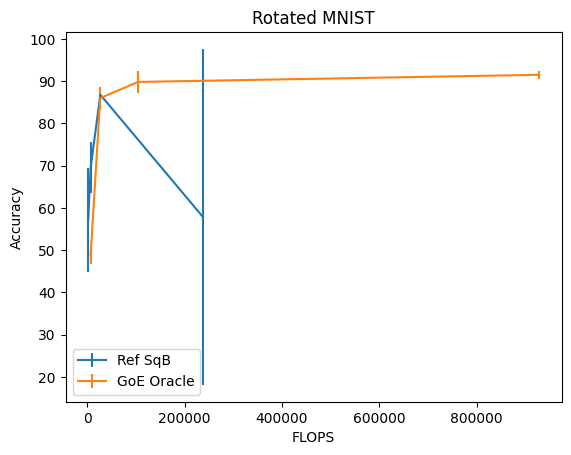

In [ ]:
model_name_to_lablel = {
    'ref_sqA': 'Ref SqA',
    'ref_sqB': 'Ref SqB',
    'goe_oracle': 'GoE Oracle',
    'goe_random': 'GoE Random',
    'goe_latent': 'GoE Latent'
}
# dont_plot = ['ref_sqA']
dont_plot = []

for model_name, statistics in compiled_results.items():
    if model_name in dont_plot:
        continue
    mean_accuracies = statistics['mean_accuracies']
    std_accuracies = statistics['std_accuracies']
    flops = statistics['flops']
    num_params = statistics['num_params']
    plt.errorbar(flops, mean_accuracies, yerr=std_accuracies, label=model_name_to_lablel[model_name])
plt.xlabel('FLOPS')
plt.ylabel('Accuracy')
plt.title('Rotated MNIST')
plt.legend()
plt.savefig('rotated_mnist_oracle.png')